# Gravity - model design and forward problem
Stefan Nielsen, Durham University, May 2024

<span style="font-size:2vw; color:red">NOTE:</span>
you need the COMPANION file <b> Init_ModelMeshGravity.ipynb </b> in the same working folder

### Initialisations:

In [1]:
# import modules
%matplotlib ipympl
%run Init_ModelMeshGravity_2024.ipynb # companion file with functions defined

## 1. Create model dimensions or "world"
- Depth is NEGATIVE is down.
- Define **top**, **bottom**, **left** and **right** edges of the model.
- Define horizons=[0] for the surface as reference
- You could add more layers in the reference model, e.g. horizons=[0,-100,-150], but you would not really need them here so I suggest to avoid it. 

In [2]:
# THESE ARE MODEL DIMENSIONS DEFINED BY USER:
top=0;bottom=-300;left=0;right=2500; # model size
horizons=[0,-100] # set surface reference at 0

## topography= True / False
- Use **topography=False** to model Bouguer anamolies --e.g., data that includes Hammer (terrain) corrections. Only the anomalies **below** horizon "0" will be included, and the model produces values at elevation 0 regardless of the topography above it.  
- Use **topography=True** to model data without elevation corrections (not free-air and not Bouguer). In this case, the model accounts for topography according to the shape of bodies that exceed elevation 0. The computed value corresponds to a measurent on top of the topography, so variable elevation. Note that 2D translational symmetry is assumed in the topography. 

In [3]:
topography=True

## 2. Create bodies (geometrical elements or shapes).
- initial plot shows reference interfaces only
- to use pre-built example model, click "Read model" m2.tmp. Otherwise design your own shapes
- to create new shapes:
    - left click to define points in a polygon
    - click "Next" to close a polygon
    - continue for as many polygons as needed 
    - polygons can intersect horizons but avoid to intersect each-other
- if topogarphy=False: points at "0" depth can be inserted slightly above "0"; the parts above 0 will be automatically eliminated 
- if topography=True: polygons will be split part above 0 and part below.
    
It is advised to use the "Save" button with a reference name in the "file" box for future use. 

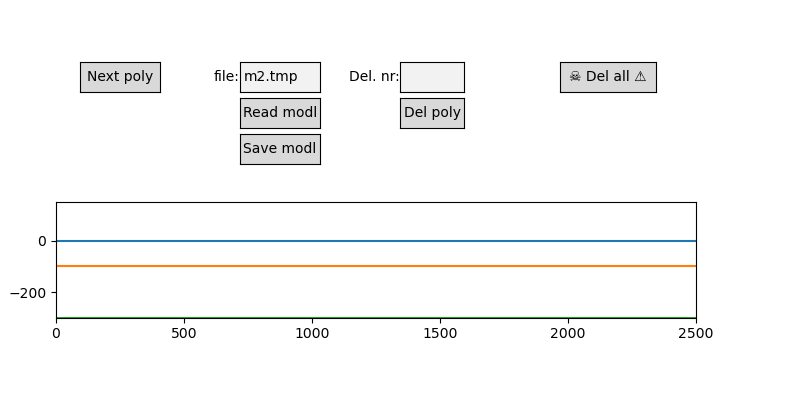

In [4]:
init_model()
fig0 = plt.figure(figsize=(8,4));
init_fig()
all_buttons()
f_plotlayrs()
check_axpos()
#
cid=fig0.canvas.mpl_connect('button_press_event', onclick2)

## 3. This checks for intersections and automatically splits polygons.

If a polygon intersects one layer it is split in two sub-polygons<br>
This will allow to define relative density with respect to the background layer in each sub-polygon.<br>
If a polygon intersects N layers it is plit in N+1 psub-polygons.<br>
If a polygon intersects the surface and topograpy=False, the part above surface is cancelled.

In [5]:
define_polygons()

LINESTRING (609.2310027072302 0, 832.6173186302183 0)
LINESTRING (616.1562854051588 -100, 969.2330165342848 -100)
LINESTRING (2072.2229827534065 -100, 2279.546885490417 -100)


## 4. Create a base geometry for the mesh

In [6]:
world = mt.createWorld(start=[left, top] , end=[right, bottom] , worldMarker=True)
pgpolygons=[];
for m, apo in enumerate(altpols):
    pgpolygons.append(mt.createPolygon(apo,isClosed=True, markerPosition=markpos[m], marker=m+2))
pgpolygons.insert(0,world)
geom = mt.mergePLC(pgpolygons)

26/05/24 - 13:28:33 - Core - WARNING - Duplicated node found for: 616.156	-100	0
26/05/24 - 13:28:33 - Core - WARNING - Duplicated node found for: 969.233	-100	0
26/05/24 - 13:28:33 - Core - WARNING - Duplicated node found for: 832.617	0	0
26/05/24 - 13:28:33 - Core - WARNING - Duplicated node found for: 2072.22	-100	0
26/05/24 - 13:28:33 - Core - WARNING - Duplicated node found for: 2279.55	-100	0


## 5. Plot geometry and marker labels for each sub-polygon for check. 
- Plots sub polygons
- Plots reference layers
- Identifies each sub-polygon with a marker
- background is labelled "1"
- each sub-polygon should have an integer lable > 1
- if any "0" label appears in the colorbar, then something went wrong...

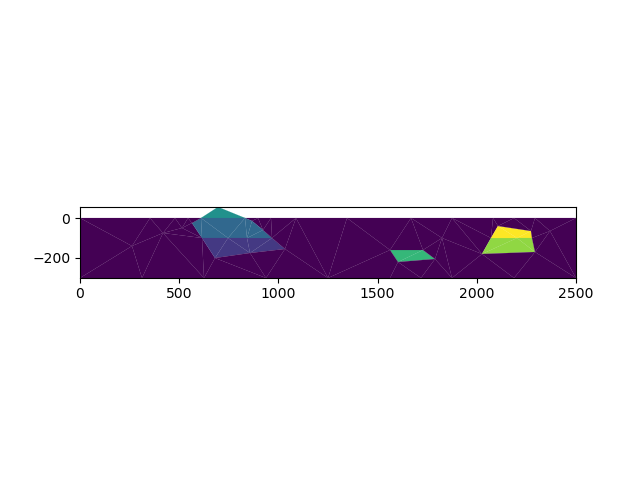

In [7]:
fig,ax=plt.subplots()
pg.show(geom,ax=ax,markers=False);
#~
for nr, marker in enumerate(geom.regionMarkers()):
    mpos=str(nr+1)
    ax.text(marker.x(), marker.y(),mpos,horizontalalignment='center',verticalalignment='center')
#
ax.set_title('marker labels');
lolo=np.asarray(layrs)
for i in range(len(layrs)):
    ax.plot(lolo[i][:,0],lolo[i][:,1],':')

## 6) Create density contrast map

- using the integer "markers" of the geometry plot, assign density CONTRAST to each subpolygon.
- note that the contrast is the change in density with respect to the background layer(s)


## Example based on model "m2.tmp" 
### (to use this example, click "read model" in the above interactive tool "create bodies") 
Here we assume that density [kg/m3] is:<br>
- First layer from top  = 1650 
- Second layer from top = 2000 background value

And that there are three bodies 
- I:  polygons 2-3-4, density 2500
- II: polygon 5, density 3000
- III:polygons 6-7,  1000
  
So the values to use in the model are the contrasts such that:

- label 1 or background reference for layers 1 and 2 = 0 contrast (reference by definition) 
- body I
  - polygon labeled "2" =   500  contrast against local background reference value (2500-2000)
  - polygon labeled "3" =   850 contrast (2500-1650) 
  - polygon labeled "4" =   2500 contrast (2500 against air or 0)
- body II
  - polygon labeled "5" = 1000
- body III
  - polygon labeled "6" = -1000
  - polygon labeled "7" = -650


In [8]:
# Assign a density value to each "Region Marker":
# [
# [regionNumber, density contrast], 
# [regionNumber, density contrast], 
# [...] 
# ]
import copy as  copy
rhomap = [    
    [1,0],  # backgournd -- no change
    [2, 500.],    [3, 850.],    [4, 2500], # body I
    [5,1000], #body II
    [6,-1000], [7, -650] # body III
    ] 

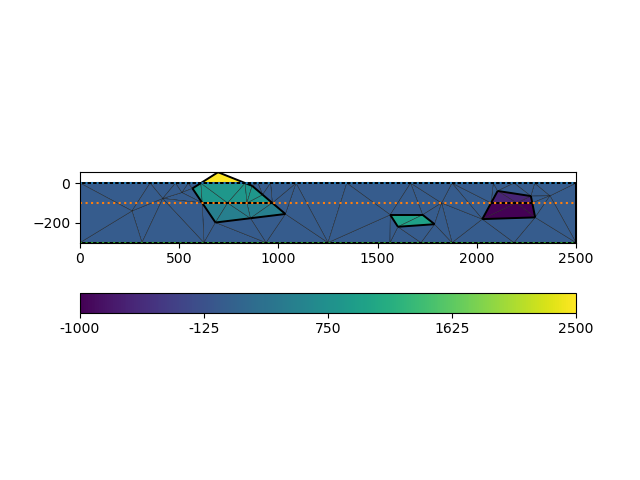

In [9]:
mesh = mt.createMesh(geom, quality=20)
mesh = mesh.createP2()
# to Create a map to set resistivity (or density) values in the appropriate regions
# Take a look at the mesh and the resistivity distribution
fig1,ax1=plt.subplots()
pg.show(mesh, data=rhomap, showMesh=True, ax=ax1);
#ax1.set_ylim(-60,20)
for i in range(len(layrs)):
    ax1.plot(lolo[i][:,0],lolo[i][:,1],':')

## 7) Read-in data file with field measurements. processed bouger anomalies:

In [10]:
# replace "data_example.csv" by your own file name
pd_real_data=pd.read_csv('data_example2.csv',dtype='float64')
real_data=np.array(pd_real_data)
x=real_data[:,0];gdat=real_data[:,1]
try:
   x
except NameError:
   x = np.arange(left,right,50) # x every 50 m cross the model

In [11]:
pnts=[]; 
# add small additional elevation above topography - Lacoste is slightly above grnd
# this may be used to simulate measurements at different heights above ground / gradient method
hovery=0.1 
for nx, xx in enumerate(x):
    line2=LineString([[xx,bottom],[xx, top-bottom]])
    ymax=horizons[0]
    for npo, pol in enumerate(altpols):
        poly=Polygon(pol)
        #ans=line1.intersection(line2)
        if poly.intersects(line2):
            ans=poly.intersection(line2)
            [x1,x2],[y1,y2]=np.asarray([p for p in ans.coords.xy[0]]),np.asarray([p for p in ans.coords.xy[1]])
            nu,nu,ymax=sorted([y1,y2,ymax])
        if ymax > 0:ymax=ymax
    if topography and ymax > 0.:
        pnts.append([xx,ymax+hovery])
    else:
        pnts.append([xx,hovery])

## 8) Compute and plot model
- Invert rhomap to mesh. 
- Solve for gravity anomaly. 
- Plot result against model

In [12]:
density = pg.solver.parseMapToCellArray(rhomap, mesh)
gc_m = solveGravimetry(mesh, density, pnts)

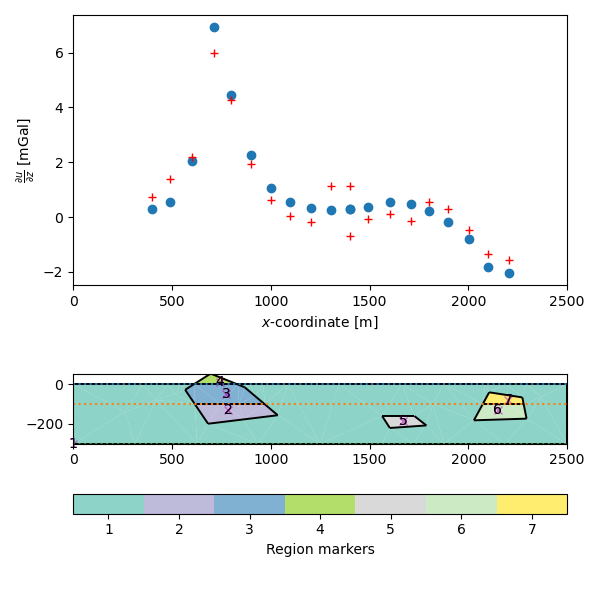

In [13]:
fig,ax = plt.subplots(2,figsize=(6,6))
ax[0].plot(x, gc_m,'o', label='Integration: Mesh')
ax[0].plot(x, gdat,'r+')
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].set_xlabel('$x$-coordinate [m]')
ax[0].set_xlim(left,right)
#

pg.show(geom,ax=ax[1],markers=False);
#
for nr, marker in enumerate(geom.regionMarkers()):
    mpos=str(nr+1)
    ax[1].text(marker.x(), marker.y(),mpos,horizontalalignment='center',verticalalignment='center')
#
lolo=np.asarray(layrs)
for i in range(len(layrs)):
    ax[1].plot(lolo[i][:,0],lolo[i][:,1],':')
fig.tight_layout()

In [29]:
# modre = np.array([x,gc_m]).T #+ np.random.default_rng())
# rng = np.random.default_rng()
# modrer = [ [mo[0],mo[1]+(2*rng.random()-1.0)]  for mo in modre]
# #modre = np.array([modre, modre]
# modrep=pd.DataFrame(modrer)
# modrep.to_csv("data_example2.csv",  index=False, header = False )

# Alternate example. Model is created by writing polygon verteces 'by hand'

## Create mesh and plot

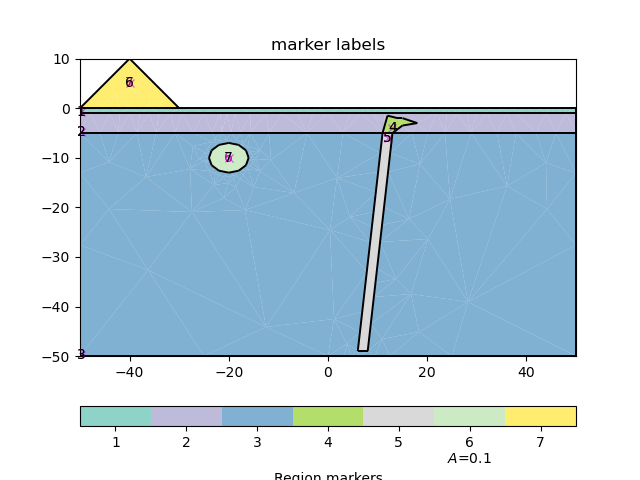

In [14]:
''' World with 3 layers, automatic markers will be 1, 2 and 3.'''

left=-50; right=50; top= 0; bottom=-50
horizons=[-1, -5] # set surface reference at 0
layrs=[[[left,i],[right,i]] for i in horizons]
world = mt.createWorld(start=[left, top], end=[right, bottom], layers=horizons, worldMarker=True)

''' Polygons defining anomalies, initial markers included, make sure each marker is inside its polygon'''

poly1 = mt.createPolygon([(11,-5), (12,-1.5), (14,-2), (15,-2),(18,-3), (15,-3.5), (13,-5)],
                        isClosed=True, marker=4, markerPosition=[13.,-4],)

poly2 = mt.createPolygon([[11,-5], [13,-5], [8,-49], [6,-49]],
                        isClosed=True, marker=5, markerPosition=[12.,-6],)

poly3 = mt.createPolygon([[-50,0],[-40,10], [-30,0]],
                        isClosed=True, marker=7, markerPosition=[-40,5])

ellip = mt.createCircle(pos=[-20, -10.], radius=[4, 3], marker=6, boundaryMarker=10, area=0.1,  
                        markerPosition=[-20,-10],)

''' Polygons are split where necessary. Markers are re-assigned'''

#geom = world + poly1 + poly2 + ellip
altpols = [np.array(poly1.positions()), np.array(poly2.positions()), np.array(poly3.positions()), np.array(ellip.positions())]
geom = mt.mergePLC([world + poly1 + poly2 + poly3 + ellip])
fig,ax=plt.subplots()
pg.show(geom,ax=ax);
for nr, marker in enumerate(geom.regionMarkers()):
    mpos=str(nr+1)
    ax.text(marker.x(), marker.y(),mpos,horizontalalignment='center',verticalalignment='center')
#
ax.set_title('marker labels');

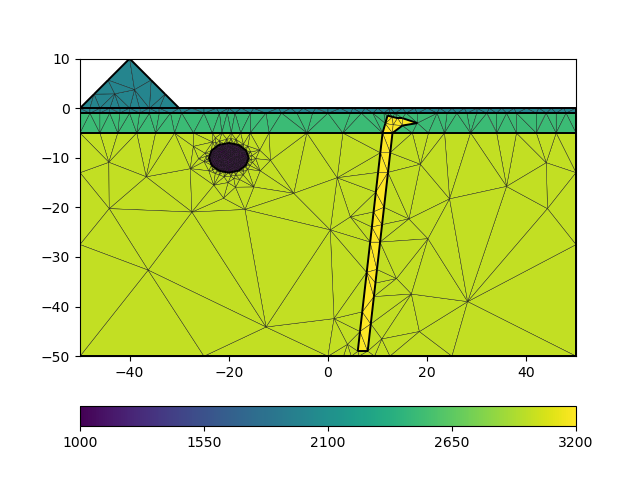

In [15]:
''' Assign a density value to each "Region Marker" from the mesh plot:
[
[regionMarker, density], 
[regionMarker, density], 
[...] 
]

'''
rhomap = [
    [1, 2000.],  # top layer
    [2, 2500.],  # second layer
    [3, 3000.],  # third layer
    [4, 3200.],  # top region of polygon -- (pink)
    [5, 3200.],  # bottom region of polygon : same as top -- (pink)
    [6, 1000.],  # elliptical region -- (yellow) 
    [7, 2000.]]
mesh = mt.createMesh(geom, quality=20)
mesh = mesh.createP2()
# to Create a map to set resistivity (or density) values in the appropriate regions
# Take a look at the mesh and the resistivity distribution
fig1,ax1=plt.subplots()
pg.show(mesh, data=rhomap, showMesh=True, ax=ax1);

In [16]:
topography= True

In [17]:
x =  np.linspace(-50,50,50)
pnts=[]; 
# add small additional elevation above topography - Lacoste is slightly above grnd
# this may be used to simulate measurements at different heights above ground / gradient method
hovery=0.1 
for nx, xx in enumerate(x):
    line2=LineString([[xx,bottom],[xx, top-bottom]])
    ymax=horizons[0]
    for npo, pol in enumerate(altpols[0:1]):
        poly=Polygon(pol)
        #ans=line1.intersection(line2)
        if poly.intersects(line2):
            ans=poly.intersection(line2)
            [x1,x2],[y1,y2]=np.asarray([p for p in ans.coords.xy[0]]),np.asarray([p for p in ans.coords.xy[1]])
            nu,nu,ymax=sorted([y1,y2,ymax])
        if ymax > 0:ymax=ymax
    if topography and ymax > 0.:
        pnts.append([xx,ymax+hovery])
    else:
        pnts.append([xx,hovery])

In [18]:
# difference between background (world) and density persturbation (poly, ellip)
rhomap_diff=[[1, 0], [2, 0], [3, 0], [4, 700.0], [5, 200.0], [6, -2000.0], [7,0]]
print(rhomap,"\n",rhomap_diff)
density = pg.solver.parseMapToCellArray(rhomap_diff, mesh)
gc_m = solveGravimetry(mesh, density, pnts)

[[1, 2000.0], [2, 2500.0], [3, 3000.0], [4, 3200.0], [5, 3200.0], [6, 1000.0], [7, 2000.0]] 
 [[1, 0], [2, 0], [3, 0], [4, 700.0], [5, 200.0], [6, -2000.0], [7, 0]]


(-50.0, 50.0)

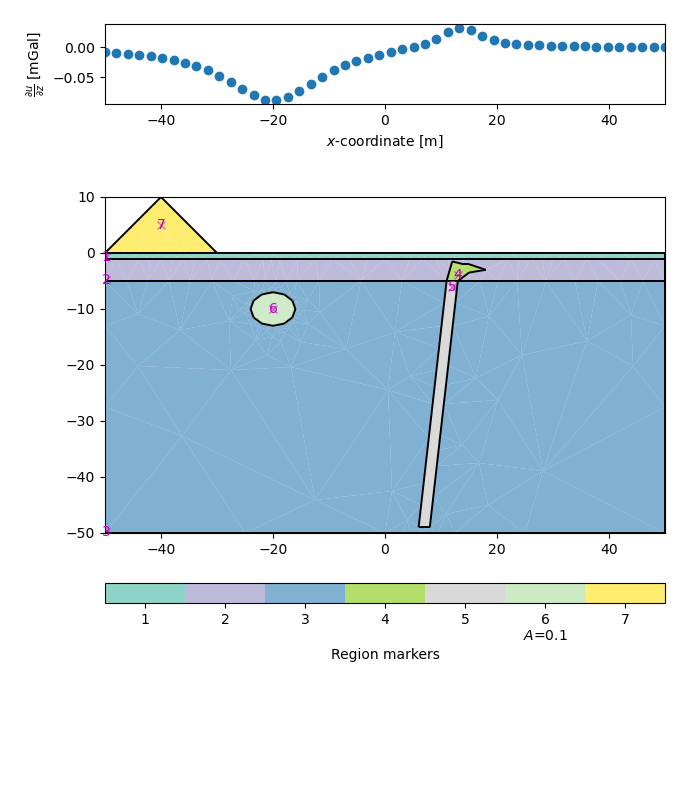

In [19]:
fig = plt.figure(figsize=(7,8))
#                  left , bot,  wid, height
ax1 = fig.add_axes([0.15,  0.87,  0.8,  0.1])
ax2 = fig.add_axes([0.15,  0.0,  .8,  1])  # add the top Axes


ax1.plot(x, gc_m,'o', label='Integration: Mesh')
#ax[0].plot(x, gdat,'r+')
ax1.set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax1.set_xlabel('$x$-coordinate [m]')
ax1.set_xlim(left,right)

pg.show(geom,ax=ax2,markers=False);
ax2.set_xlim(left,right)

